# Chart Library Notebook

This notebook will begin the basis for production level chart library using the agmktdb.

In [1]:
import os

# Data science
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Database
from sqlalchemy import create_engine
import psycopg2
import agmkt_pkg.nass as nass
import agmkt_pkg.env_vars as env_vars
import agmkt_pkg.utils as utils


print('Libraries imported!!')

Libraries imported!!


# Create SELECT statement to pull raw data

In [2]:
# create sql connection
user = env_vars.mktdb_user()
password = env_vars.mktdb_passwd()
server = env_vars.mktdb_server()


connection_string = f'postgresql://{user}:{password}@{server}/mktdb'
eng = create_engine(connection_string)
conn = eng.connect()

In [3]:
stmt_dict = {'COMMODITY_DESC':'CORN', 'PRODN_PRACTICE_DESC':'ALL PRODUCTION PRACTICES', 
             'UTIL_PRACTICE_DESC':'GRAIN', 
            # 'CLASS_DESC':'OIL TYPE',
             'STATISTICCAT_DESC':'AREA HARVESTED', 'UNIT_DESC':'ACRES', 'AGG_LEVEL_DESC':'NATIONAL', 'REFERENCE_PERIOD_DESC':'YEAR'}

df = nass.df_time_series_chart(stmt_dict=stmt_dict, db_connect=conn)


# Manipulate data for data visualization

In [4]:
# print(df.info())

# df_trim = utils.keep_cols(df, default_cols=['SHORT_DESC'])

# print(df_trim.info())


# Create Visualziation and save image to folder

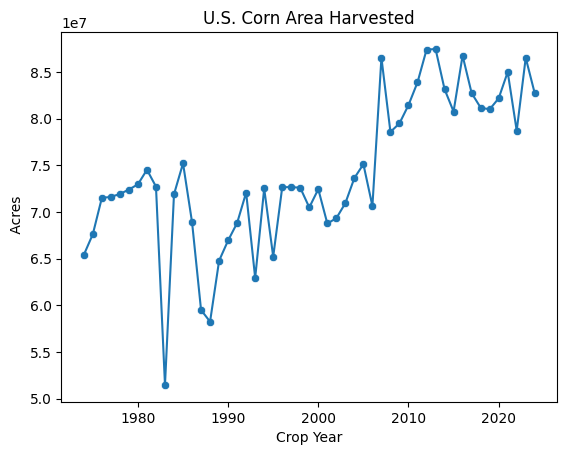

In [5]:
scale_dict = {
    'Unit':{'value':1, 'label':''},
    'Thousand':{'value':1e3, 'label':'Thousand'},
    'Million':{'value':1e6, 'label':'Million'},
    'Billion':{'value':1e9, 'label':'Billion'},
}

df_viz = df[df['date'].dt.year >= df['date'].dt.year.max() - 50]

str_commodity = stmt_dict['COMMODITY_DESC'].title()
str_statistic = stmt_dict['STATISTICCAT_DESC'].title()
str_unit = stmt_dict['UNIT_DESC'].title()

plt.subplot()
scale = 'Unit'
scale_value = scale_dict[scale]['value']
scale_label = scale_dict[scale]['label']
sns.lineplot(data=df_viz, x='date', y=df['VALUE']/scale_value)
sns.scatterplot(data=df_viz, x='date', y=df['VALUE']/scale_value)
plt.title(f'U.S. {str_commodity} {str_statistic}')
plt.ylabel(f'{scale_label} {str_unit}')
plt.xlabel('Crop Year')
plt.show()

'Saved to corn_area harvested.png'

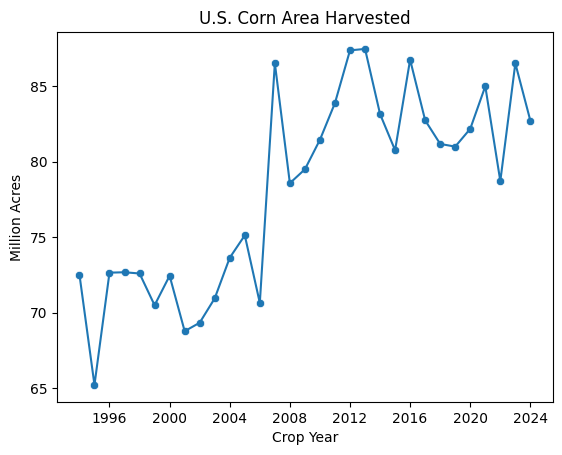

In [6]:
nass.time_series_chart(df, stmt_dict, './docs', years = 30, scale='Million')